In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 25)

import pdb

from __future__ import division

In [2]:
data_dir = "data/"

Import outbreak data

In [3]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0)
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [4]:
measles_data = measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})

Sao Paulo population by district

In [5]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [6]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [7]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Plot of cumulative cases by district

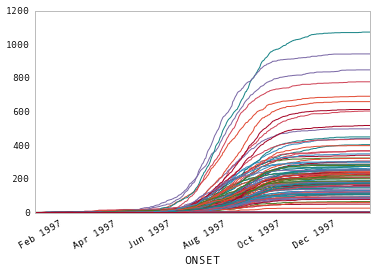

In [8]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

Top 5 districts by number of cases

In [9]:
totals = measles_onset_dist.sum()
totals.sort(ascending=False)
totals[:5]

DISTRICT
GRAJAU             1074
JARDIM ANGELA       944
CAPAO REDONDO       849
JARDIM SAO LUIZ     778
CAMPO LIMPO         692
dtype: float64

## Chain Binomial Transmission Model

As a baseline for comparison, we can fit a model to all the clinically-confirmed cases, regardless of lab confirmation status. For this, we will use a simple chain binomial model, which will be fit using MCMC.

This model fits the series of 2-week infection totals as a set of Binomial models:

\\[Pr(I_{t+1} | S_t, p_t) = \text{Bin}(S_t, p_t) \\]

Where the binomial probability is modeled as:

\\[p_t = 1 - \exp\(-\lambda_t\)\\]

\\[\lambda_t = \frac{B_t I_t}{N}\\]

\\[B_j = B_0\\]

which allows the effective reproductive number to be calculated as:

\\[R_t = \frac{\beta S_t}{N}\\]

### Confirmation Sub-model

Rather than assume all clinical cases are true cases, we can adjust the model to account for lab confirmation probability. This is done by including a sub-model that estimates age group-specific probabilities of confirmation, and using these probabilities to estimate the number of lab-confirmed cases. Theses estimaes are then plugged into the model in place of the clinically-confirmed cases.

Age classes are defined in 5-year intervals.

In [10]:
age_classes = [0,5,10,15,20,25,30,35,40,45,50,55,60,66,70,75,100]
measles_data.dropna(subset=['AGE'], inplace=True)
measles_data['AGE_GROUP'] = pd.cut(measles_data.AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [11]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

In [12]:
lab_subset = measles_data[(CONFIRMED | DISCARDED) & measles_data.YEAR_AGE.notnull() & measles_data.COUNTY.notnull()].copy()
lab_subset.loc[lab_subset.YEAR_AGE > 75, 'YEAR_AGE'] = 75
age = lab_subset.YEAR_AGE.astype(int).values
ages = lab_subset.YEAR_AGE.astype(int).unique()
counties = lab_subset.COUNTY.unique()
y = (lab_subset.CONCLUSION=='CONFIRMED').values

Extract cases by age and time.

In [13]:
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.levels.tolist().index(i) for i in age_group])

/usr/local/lib/python3.4/site-packages/pandas/core/categorical.py:462: FutureWarning: Accessing 'levels' is deprecated, use 'categories'
  warn("Accessing 'levels' is deprecated, use 'categories'", FutureWarning)


In [14]:
# Get index from full crosstabulation to use as index for each district
dates_index = measles_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().index

In [15]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [16]:
N = sp_pop.ix[unique_districts, 'Total'].dropna()

In [17]:
sp_districts = N.index.values
len(sp_districts)

93

In [18]:
all_district_data = []
all_confirmed_cases = []
for d in sp_districts:
    
    # All bi-weekly unconfirmed and confirmed cases
    district_data = measles_data[measles_data.DISTRICT==d]
    district_counts_2w = district_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).resample('2W', how='sum')
    all_district_data.append(district_counts_2w)
    
    # All confirmed cases, by district
    confirmed_data = district_data[district_data.CONCLUSION!='CONFIRMED']
    confirmed_counts = confirmed_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).sum()
    all_confirmed_cases.append(confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique()).fillna(0))

Time series of cases by district, summarized in 2-week intervals

In [19]:
# Sum over ages for susceptibles
sp_cases_2w = [dist.sum(1) for dist in all_district_data]

In [20]:
# Ensure the age groups are ordered
I_obs = np.array([dist.reindex_axis(measles_data['AGE_GROUP'].unique(), 
                            axis=1).fillna(0).values.astype(int) for dist in all_district_data])

In [21]:
measles_data['AGE_GROUP'].unique()

array(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 45)', '[45, 50)', '[50, 55)',
       '[55, 60)', '[60, 66)', '[66, 70)', '[70, 75)', '[75, 100)'], dtype=object)

Check shape of data frame

In [22]:
assert I_obs.shape == (93, 28, 16)

### Spatial distance between districts

In [23]:
import geopandas as gpd

shp = gpd.GeoDataFrame.from_file("Sao Paulo/Brazil_full/BRA_adm3.shp")

In [24]:
district_names = N.index.unique()

In [25]:
import trans
shp['district_name'] = shp.NAME_3.apply(
    lambda x: trans.trans(x).upper())

In [26]:
sp_shp = shp[shp.NAME_2=='São Paulo'].set_index('district_name')

In [27]:
sp_shp.ix['CAMPO LIMPO']

ENGTYPE_3                                              District
HASC_3                                                     None
ID_0                                                         32
ID_1                                                        454
ID_2                                                       8816
ID_3                                                      13779
ISO                                                         BRA
NAME_0                                                   Brazil
NAME_1                                                São Paulo
NAME_2                                                São Paulo
NAME_3                                              Campo Limpo
NL_NAME_3                                                  None
REMARKS_3                                                  None
Shape_Area                                          0.001116783
Shape_Leng                                            0.1537662
TYPE_3                                  

In [28]:
centroids = sp_shp.geometry.centroid

In [29]:
distance_matrix = pd.concat([sp_shp.geometry.distance(o) for o in sp_shp.geometry],
                     axis=1)
distance_matrix.columns = sp_shp.index

In [30]:
min_x, min_y = sp_shp.bounds.min()[:2]
max_x, max_y = sp_shp.bounds.max()[2:]

In [31]:
assert (distance_matrix.index == centroids.index).all()

In [32]:
centroid_xy = np.array([[c.x, c.y] for c in sp_shp.geometry.centroid])

In [33]:
_beta = -100
np.exp(_beta*distance_matrix).values.round(2)[0]

array([ 1.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.12,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  0.  ,  0.  ,
        1.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.01,  0.  ,  0.  ,  0.  ,
        0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.18,  0.  ,  0.  ,  0.  ,
        0.  ,  0.04,  1.  ,  0.  ,  0.  ,  0.  ,  0.1 ,  0.01,  0.  ,
        0.  ,  0.19,  0.  ,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  1.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.11,  0.  ,  1.  ,
        0.02,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.01,  0.  ,  0.02,
        0.03,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.1 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.65,
        0.  ,  0.01,  0.  ,  0.  ,  0.  ,  1.  ])

### Spatial decision model

We attempt to estimate $R_t$ for a truncated subset of the data, to simulate a decision-maker's information during (rather than after) an outbreak. This essentially involves turning part of the time series into missing data, and running the model.

This is an example of creating a mask for data not observed by the decision date.

In [34]:
np.array([np.resize(all_district_data[0].index > '1997-06-15', I_obs[0].T.shape).T]*len(all_district_data))

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True, 

In [35]:
from pymc import MCMC, Matplot
from pymc import (Uniform, DiscreteUniform, Beta, Lambda, Binomial, Normal, Poisson, 
                  NegativeBinomial, observed, negative_binomial_like, Lognormal, Exponential, binomial_like,
                  stochastic, potential, invlogit, TruncatedNormal, Binomial, Gamma)
from pymc import (HalfCauchy, deterministic, MvNormalCov, Bernoulli, potential, Uninformative, Multinomial,
                  rmultinomial, rbinomial)

from pymc.gp import *
from pymc.gp.cov_funs import matern

In [126]:
def measles_model(obs_date, confirmation=True, spatially_weighted=True, all_traces=False):
    
    ### Confirmation sub-model
    
    if confirmation:

        # Specify priors on age-specific means
        age_classes = np.unique(age_index)

        mu = Normal("mu", mu=0, tau=0.0001, value=[0]*len(age_classes))
        sig = HalfCauchy('sig', 0, 25, value=1)
        var = sig**2
        cov = Uniform('cov', -1000, 1000, value=0)


        # Build variance-covariance matrix with first-order correlation among age classes
        @deterministic
        def Sigma(var=var, cov=cov):
            I = np.eye(len(age_classes))*var
            E = np.diag(np.ones(len(age_classes)-1), k=-1)*cov
            return I + E + E.T


        # Age-specific probabilities of confirmation as multivariate normal random variables
        beta_age = MvNormalCov("beta_age", mu=mu, C=Sigma, value=[1]*len(age_classes))
        p_age = Lambda('p_age', lambda t=beta_age: invlogit(t))

        @deterministic(trace=False)
        def p_confirm(beta=beta_age):
            return invlogit(beta[age_index])


        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=y, observed=True)


    '''
    Missing data sub-model 
    
    We treat observations later than the decision date as missing data. This is 
    implemented as a `masked_array` in NumPy, which requires a boolean mask to identify missing values.
    '''
    missing_mask = all_district_data[0].index > obs_date
    district_mask = np.resize(missing_mask, I_obs[0].T.shape).T
    
    # Index to the observation period
    current_index = (~missing_mask).sum()-1

    I_obs_masked = ma.masked_array(I_obs,
                                   mask=np.array([district_mask]*len(all_district_data)),
                                   fill_value=1)


    # Index for observation date, used to index out values of interest from the model.
    t_obs = (~missing_mask).sum() - 1


    # Imputed infecteds
    I_imp = DiscreteUniform('I_imp', 0, 2000, value=I_obs_masked, observed=True)


    ### Chain binomial model for disease dynamics

    if confirmation:
        
        # Confirmed cases
        @stochastic(trace=all_traces, dtype=int)
        def I(value=(I_imp.value*0.7).astype(int), n=I_imp, p=p_age):
            return np.sum([np.sum([binomial_like(vj[:,i], nj[:,i], p[i]) for i in range(len(p))]).sum(0) 
                                    for vj, nj in zip(value, n)])

    else:
        
        I = I_imp


    # Infecteds at time $t_{obs}$
    It = Lambda('It', lambda I=I: I.sum(0)[t_obs])


    # Calculate susceptibles from total number of infections
    @deterministic(trace=all_traces)
    def S(I=I):
        return np.array([Ij.sum() - np.array([Ij[:i].sum() for i in range(len(Ij))]) for Ij in I])


    # Total infecteds until time t_obs, by age
    I_total = Lambda('I_total', lambda I=I: I[:,:t_obs].sum(0).sum(0))
    # Age distribution of infecteds
    age_dist = Lambda('age_dist', lambda I=I_total: I/I.sum())
    
    # Susceptibles at time t
    S_t = Lambda('S_t', lambda S=S: S[:, t_obs])
    
    # Susceptibles at time t, by age
    @deterministic
    def S_age(S=S_t, p=age_dist):
        return np.array([rmultinomial(si, p) for si in S])  
    
    @deterministic
    def vacc_5(S=S_age):
        # Vaccination of 15 and under
        p = [0.95] + [0]*15
        return rbinomial(S[current_index], p)
    
    # Proportion of susceptibles vaccinated
    pct_5 = Lambda('pct_5', lambda V=vacc_5, S=S_age: float(V.sum())/S[current_index].sum())
    
    @deterministic
    def vacc_15(S=S_age):
        # Vaccination of 15 and under
        p = [0.95]*3 + [0]*13
        return rbinomial(S[current_index], p)
    
    # Proportion of susceptibles vaccinated
    pct_15 = Lambda('pct_15', lambda V=vacc_15, S=S_age: float(V.sum())/S[current_index].sum())
    
    @deterministic
    def vacc_30(S=S_age):
        # Vaccination of 30 and under
        p = [0.95]*6 + [0]*10
        return rbinomial(S[current_index], p)
    
    # Proportion of 30 and under susceptibles vaccinated
    pct_30 = Lambda('pct_30', lambda V=vacc_30, S=S_age: float(V.sum())/S[current_index].sum())
    
    @deterministic
    def vacc_adult(S=S_age):
        # Vaccination of adults under 30 (and young kids)
        p = [0.95, 0, 0, 0, 0.95, 0.95] + [0]*10
        return rbinomial(S[current_index], p)
    
    # Proportion of adults under 30 (and young kids)
    pct_adult = Lambda('pct_adult', lambda V=vacc_adult, S=S_age: float(V.sum())/S[current_index].sum())
    
    # Transmission parameter
    beta = Gamma('beta', 1, 0.1, value=10) 


    '''
    Calculation of the effective reproduction number depends on whether we believe that the districts 
    are independent or not. If not (`spatially_weighted = True`), both the number of susceptibles and the 
    denominator population are calculated as a distance-weighted average of all the districts in Sao Paulo.
    '''
    if spatially_weighted:

        geo_mesh = np.transpose([np.linspace(min_x, max_x),
                                np.linspace(min_y, max_y)])

        # Vague prior for the overall mean
        m = Uninformative('m', value=0)

        def constant(x, val):
            return np.zeros(x.shape[:-1],dtype=float) + val

        @deterministic
        def M(m=m):
            return Mean(constant, val=m)

        # ==================
        # = The covariance =
        # ==================

        # Vague priors for the amplitude and scale
        amp = Exponential('amp', 1e-5, value=1)
        scale = Exponential('scale',1e-5, value=0.1)
        @deterministic
        def C(amp=amp, scale=scale):
            return FullRankCovariance(exponential.euclidean, amp = amp, scale = scale)

        # ===================
        # = The GP submodel =
        # ===================
        zeta = GPSubmodel('zeta', M, C, geo_mesh)

        z_eval = Lambda('z_eval', lambda z=zeta.f(centroid_xy): z)



    alpha = Exponential('alpha', 1, value=0.0001)


    if spatially_weighted:
        Rt = Lambda('Rt', lambda B=beta, S=S, z=z_eval, a=alpha: ((B * (1 + a*z) * S.T) / N.values).T)
    else:
        Rt = Lambda('Rt', lambda B=beta, S=S: ((B * S).T / N.values).T)


    # Effective reproduction number at time of observation, and implied vaccination target
    Rt_obs = Lambda('Rt_obs', lambda r=Rt: r[:, t_obs])
    vaccination_target = Lambda('vaccination_target', lambda r=Rt_obs: np.maximum(1-1./r, 0))


    # Force of infection, assuming mass action transmission
    if spatially_weighted:
        lam = Lambda('lam', lambda B=beta, I=I, z=z_eval, a=alpha: 
                     np.array([(B * (1 + zj) * Ij) / nj for Ij,nj,zj in zip(I, N.values, a*z)]), 
                     trace=False)
    else:
        lam = Lambda('lam', lambda B=beta, I=I: np.array([(B * Ij) / nj for Ij,nj in zip(I, N.values)]), 
                     trace=False)


    # 2-week infection probabilities
    p = Lambda('p', lambda lam=lam: 1. - np.exp(-lam) + 1e-6, trace=False)


    # Binomial likelihood for observed cases
    @potential
    def new_cases(p=p, I=I, S=S): 
        return np.sum([[binomial_like(i, s, pt) for pt,i,s in zip(pj[:t_obs], Ij[:t_obs], Sj[:t_obs])] 
                                                   for pj,Ij,Sj in zip(p, I, S)])

    return locals()

In [131]:
model_june_noconf = MCMC(measles_model('1997-06-15', 
                                       spatially_weighted=False, 
                                       confirmation=False))

In [132]:
model_june_noconf.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 931.2 sec

In [133]:
model_july_noconf = MCMC(measles_model('1997-07-15', spatially_weighted=False, confirmation=False))

In [134]:
model_july_noconf.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 1026.0 sec

In [135]:
model_june = MCMC(measles_model('1997-06-15', spatially_weighted=False))

In [136]:
model_june.sample(50000, 40000)

 [-----------------100%-----------------] 50001 of 50000 complete in 2052.6 sec

In [137]:
model_july = MCMC(measles_model('1997-07-15', spatially_weighted=False))

In [138]:
model_july.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 2060.2 sec

In [139]:
Rt_june = model_june.Rt.stats()

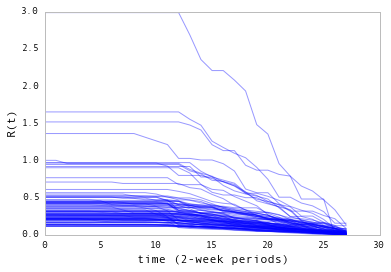

In [140]:
plt.plot(Rt_june['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


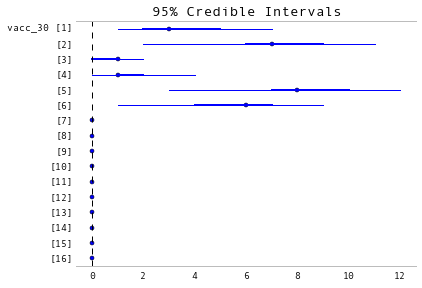

In [141]:
Matplot.summary_plot(model_june.vacc_30)

Plotting pct_15


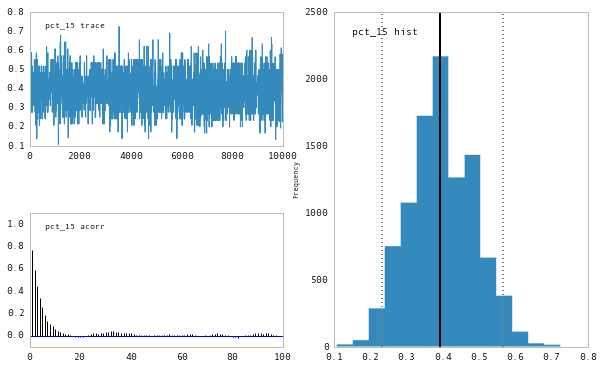

In [142]:
Matplot.plot(model_june.pct_15)

Plotting pct_30


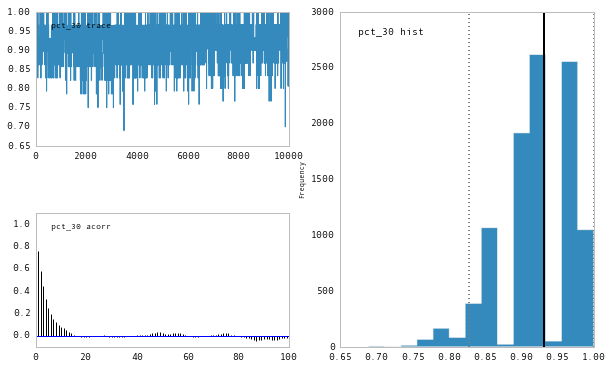

In [143]:
Matplot.plot(model_june.pct_30)

In [165]:
model_june.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.124            0.061            0.002            [ 0.033  0.25 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.032            0.071           0.107          0.167         0.25
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.398            0.091            0.003            [ 0.233  0.567]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.233            0.333           0.393          0.464         0.571
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	--------------------

In [167]:
model_june_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.163            0.001            0.0              [ 0.161  0.165]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.161            0.163           0.163          0.164         0.165
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.464            0.001            0.0              [ 0.462  0.467]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.461            0.463           0.464          0.465         0.467
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [168]:
model_july.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.105            0.047            0.001            [ 0.02   0.196]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.022            0.067           0.104          0.133         0.208
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.291            0.066            0.002            [ 0.174  0.422]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.167            0.244           0.289          0.333         0.422
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [169]:
model_july_noconf.summary(['pct_5', 'pct_15', 'pct_30', 'pct_adult'])


pct_5:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.133            0.001            0.0              [ 0.131  0.135]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.131            0.132           0.133          0.133         0.135
	

pct_15:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.365            0.001            0.0              [ 0.362  0.367]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.362            0.364           0.365          0.366         0.367
	

pct_30:
 
	Mean             SD               MC Error        95% HPD interval
	-------------------

In [149]:
Rt_july = model_july.Rt.stats()

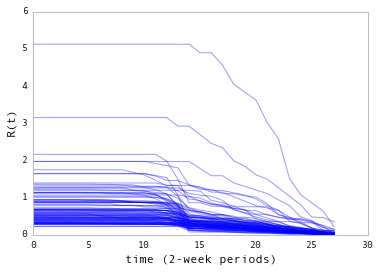

In [150]:
plt.plot(Rt_july['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

In [151]:
Rt_june_noconf = model_june_noconf.Rt.stats()

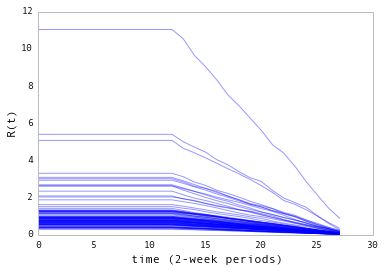

In [152]:
plt.plot(Rt_june_noconf['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


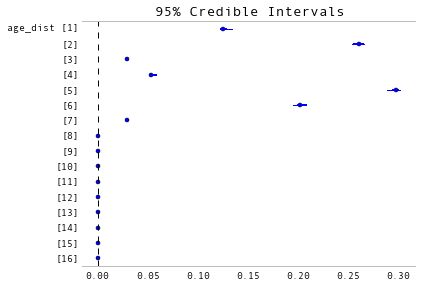

In [153]:
Matplot.summary_plot(model_june.age_dist)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


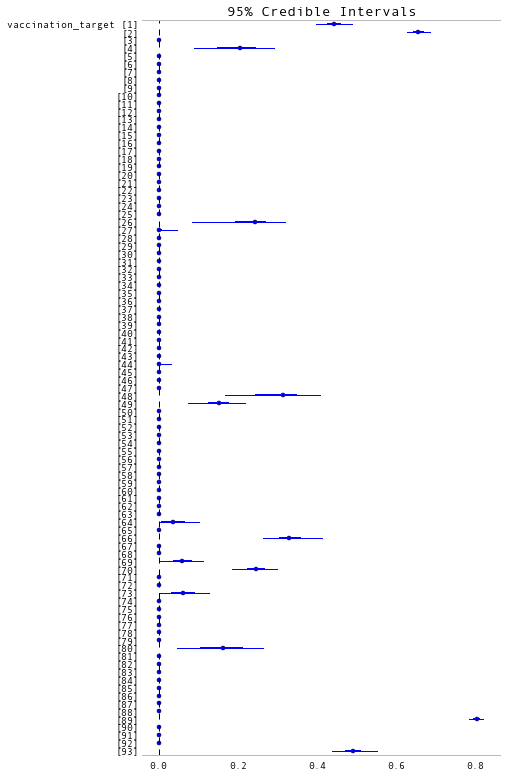

In [154]:
plt.figure(figsize=(8,12))
Matplot.summary_plot(model_july.vaccination_target)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


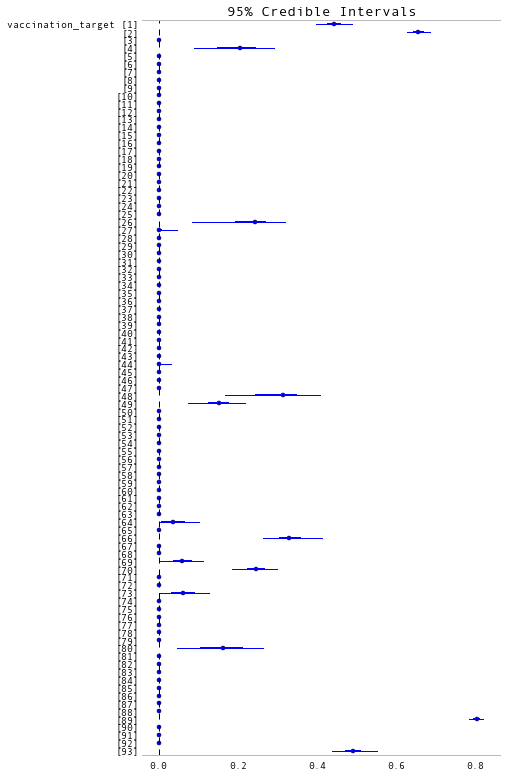

In [155]:
plt.figure(figsize=(8,12))
Matplot.summary_plot(model_july.vaccination_target)

Plotting alpha


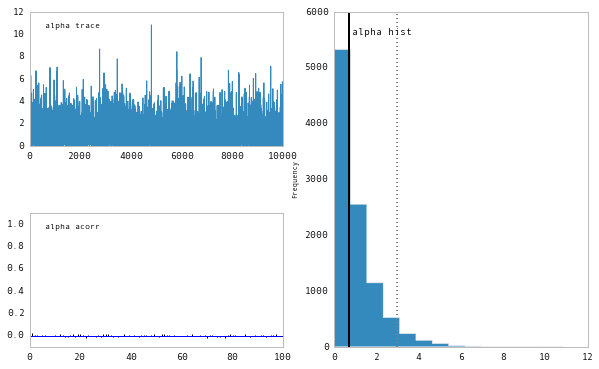

In [157]:
Matplot.plot(model_june.alpha)

## Mapping spatial effects

In [158]:
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

lllat=-24
urlat=-23.3
lllon=-47
urlon=-46.3

SP_base = Basemap(ax=None, lon_0=(urlon + lllon) / 2, lat_0=(urlat + lllat) / 2,
        llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon, urcrnrlon=urlon, 
                  resolution='i',
                 epsg='4326')

In [159]:
SP_dist = gpd.GeoDataFrame.from_file('Sao Paulo/Brazil_full/BRA_adm3.shp').to_crs({'proj': 'longlat', 
                                                                               'ellps': 'WGS84', 
                                                                               'datum': 'WGS84'})

In [160]:
SP_dist['DIST_NAME'] = [trans.trans(_).upper() for _ in SP_dist.NAME_3]

In [161]:
SP_dist.head()

,ENGTYPE_3,HASC_3,ID_0,ID_1,ID_2,ID_3,ISO,NAME_0,NAME_1,NAME_2,...,NL_NAME_3,REMARKS_3,Shape_Area,Shape_Leng,TYPE_3,VALIDFR_3,VALIDTO_3,VARNAME_3,geometry,DIST_NAME
0,District,None,32,434,4112,4868,BRA,Brazil,Bahia,Piritiba,...,None,None,0.041872,1.033621,Distrito,Unknown,Present,None,POLYGON ((-40.38711999999998 -11.6031739999999...,PIRITIBA
1,District,None,32,434,4112,4869,BRA,Brazil,Bahia,Piritiba,...,None,None,0.008318,0.375198,Distrito,Unknown,Present,None,POLYGON ((-40.62181199999998 -11.7807669999999...,PORTO FELIZ
2,District,None,32,434,4113,4870,BRA,Brazil,Bahia,Planaltino,...,None,None,0.024796,0.751948,Distrito,Unknown,Present,None,POLYGON ((-40.11320899999998 -13.3009799999998...,IBITIGUIRA
3,District,None,32,434,4113,4871,BRA,Brazil,Bahia,Planaltino,...,None,None,0.027577,0.776489,Distrito,Unknown,Present,None,POLYGON ((-40.15503999999993 -13.1252719999998...,NOVA ITAIPE
4,District,None,32,434,4113,4872,BRA,Brazil,Bahia,Planaltino,...,None,None,0.025845,1.052880,Distrito,Unknown,Present,None,POLYGON ((-40.38104599999997 -13.2141219999999...,PLANALTINO


In [162]:
SP_dist.NAME_3.unique()

array(['Piritiba', 'Porto Feliz', 'Ibitiguira', ..., 'Tupiratins',
       'Wanderlândia', 'Xambioá'], dtype=object)

In [163]:
district_names

array(['BRAS', 'BARRA FUNDA', 'FREGUESIA DO O', 'CAMBUCI', 'PENHA',
       'BRAZILANDIA', 'SANTA CECILIA', 'CASA VERDE', 'CAPAO REDONDO',
       'CONSOLACAO', 'JAGUARE', 'CIDADE ADEMAR', 'CIDADE TIRADENTES',
       'SAPOPEMBA', 'MOOCA', 'CANGAIBA', 'SAUDE', 'SANTANA',
       'JARDIM ANGELA', 'CAMPO LIMPO', 'VILA MARIANA', 'VILA CURUCA',
       'CIDADE DUTRA', 'ARTUR ALVIM', 'JARDIM HELENA', 'SE', 'LAPA',
       'JARDIM PAULISTA', 'JABAQUARA', 'PINHEIROS', 'RIO PEQUENO',
       'GRAJAU', 'VILA SONIA', 'IGUATEMI', 'SANTO AMARO', 'LIMAO',
       'PERDIZES', 'SAO DOMINGOS', 'SAO LUCAS', 'PIRITUBA',
       'RAPOSO TAVARES', 'VILA FORMOSA', 'BELEM', 'REPUBLICA',
       'SAO MATEUS', 'TREMEMBE', 'VILA PRUDENTE', 'VILA LEOPOLDINA',
       'BOM RETIRO', 'JOSE BONIFACIO', 'PARELHEIROS', 'PERUS', 'PEDREIRA',
       'JARAGUA', 'LAJEADO', 'SACOMA', 'ITAIM PAULISTA', 'TUCURUVI',
       'VILA MEDEIROS', 'LIBERDADE', 'TATUAPE', 'CARRAO', 'BELA VISTA',
       'BUTANTA', 'SAO RAFAEL', 'MORUMBI', 'AGUA R

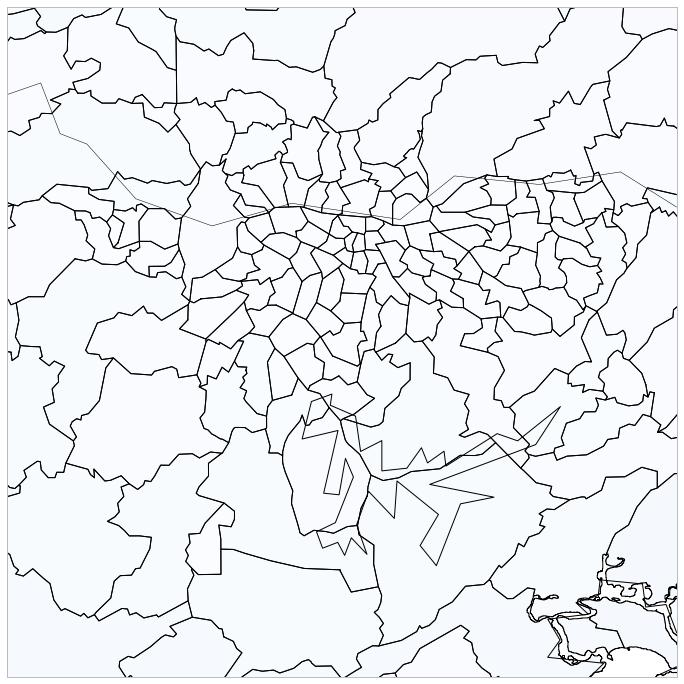

In [164]:
from matplotlib.pyplot import cm

map_fig = plt.figure(figsize=(16,12))
map_ax = plt.gca()
SP_base.drawcoastlines()
SP_base.drawrivers()

SP_dist.plot(column='Shape_Leng', colormap=cm.Blues, axes=map_ax)